# Frameworks for parallel computing
**Python for HPC course**

Max Planck Computing and Data Facility, Garching

## Outline

* Motivation
* Overview on Parallel Frameworks
* Example: Dask
    * Basic concepts
    * Dask-MPI on a Slurm cluster

## Why Python frameworks for parallel computing?

* Scale from a single local computer to distributed parallel resources, (ideally) with a minimum of code modifications
* Avoid the complexity of handling interprocess/internode communication explicitly ($\to$ MPI), better let the framework handle this!
* Use cases: Data parallel problems that can be decomposed into tasks, e.g. processing, reduction, analysis of large amounts of data, training of certain neural networks, etc.

## Overview on parallel frameworks (selection)

* [Apache Spark](https://spark.apache.org): designed for distributed big data analytics, features include SQL, distributed caching, multi-language bindings including Python
* [Dask](https://www.dask.org): parallel distributed computing, provides an implementation of the NumPy API (similarly for Pandas and scikit-learn) in combination with a powerful task scheduler, feels "pythonic"
* [Ray](https://www.ray.io): core library for distributed computing, plus growing ecosystem with specific libraries (very often for AI applications)

## Background: Cloud vs HPC environments

### How to run and scale Python codes using such parallel frameworks?

* Cloud
    * (software) design often centered around web services
    * scaling works e.g. via container orchestration systems (e.g. Kubernetes)
    * Python frameworks for parallel computing are often designed with Cloud environments in mind (as these are available to a broader audience in contrast to 'real' HPC systems)

* HPC
    * not designed to run web services (e.g. dashboards, scheduler services)
    * workloads are submitted via batch jobs
    * non-interactive use highly preferred
    * sometimes workarounds are needed to get Python frameworks for parallel computing to run (exception: Dask-MPI)

## Example: Dask

* Dask is a library for parallel distributed computing in Python
* Components
    * resource abstraction called Cluster (a potentially distributed scalable pool of workers), e.g.
        * LocalCluster() : default, workers on local machine
        * SSHCluster() : workers on remote machines accessible via SSH
        * KubeCluster() : workers on pods running in a Kubernetes cluster
        * MPI-based cluster : workers running as MPI tasks on an HPC system
    * dynamic task scheduler
    * parallel collections such as arrays and dataframes

![Dask Concepts](fig/dask-overview.svg)
(image credit: dask documentation)

### Dask array

* *Dask Array* implements a subset of the NumPy ndarray interface using blocked algorithms
* it cuts up the large array into many small arrays for parallel distributed processing
* Dask blocked algorithms are mapped to tasks and coordinated using Dask graphs
* not limited to native NumPy, supports generic ndarray-like implementations (CuPy, H5PY)

![Dask Array](fig/dask-array.svg)
(image credit: dask documentation)

In [16]:
# create a chunked Dask array from a NumPy array
import numpy as np
import dask.array as da

data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [17]:
# inspect information about the chunking
a.chunksize

(100, 100)

In [18]:
# inspect information about a particular chunk of data
a.blocks[1, 3]

dask.array<blocks, shape=(100, 100), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [19]:
# indexing/slicing works just as with NumPy
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

In [20]:
# Lazy evaluation (only a task graph is created when slicing), we need to call compute() 
# explicitly to get the result from any Dask object!
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

In [21]:
# Create a Dask object to compute the mean value over the distributed array
a_mean = a.mean()
a_mean

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

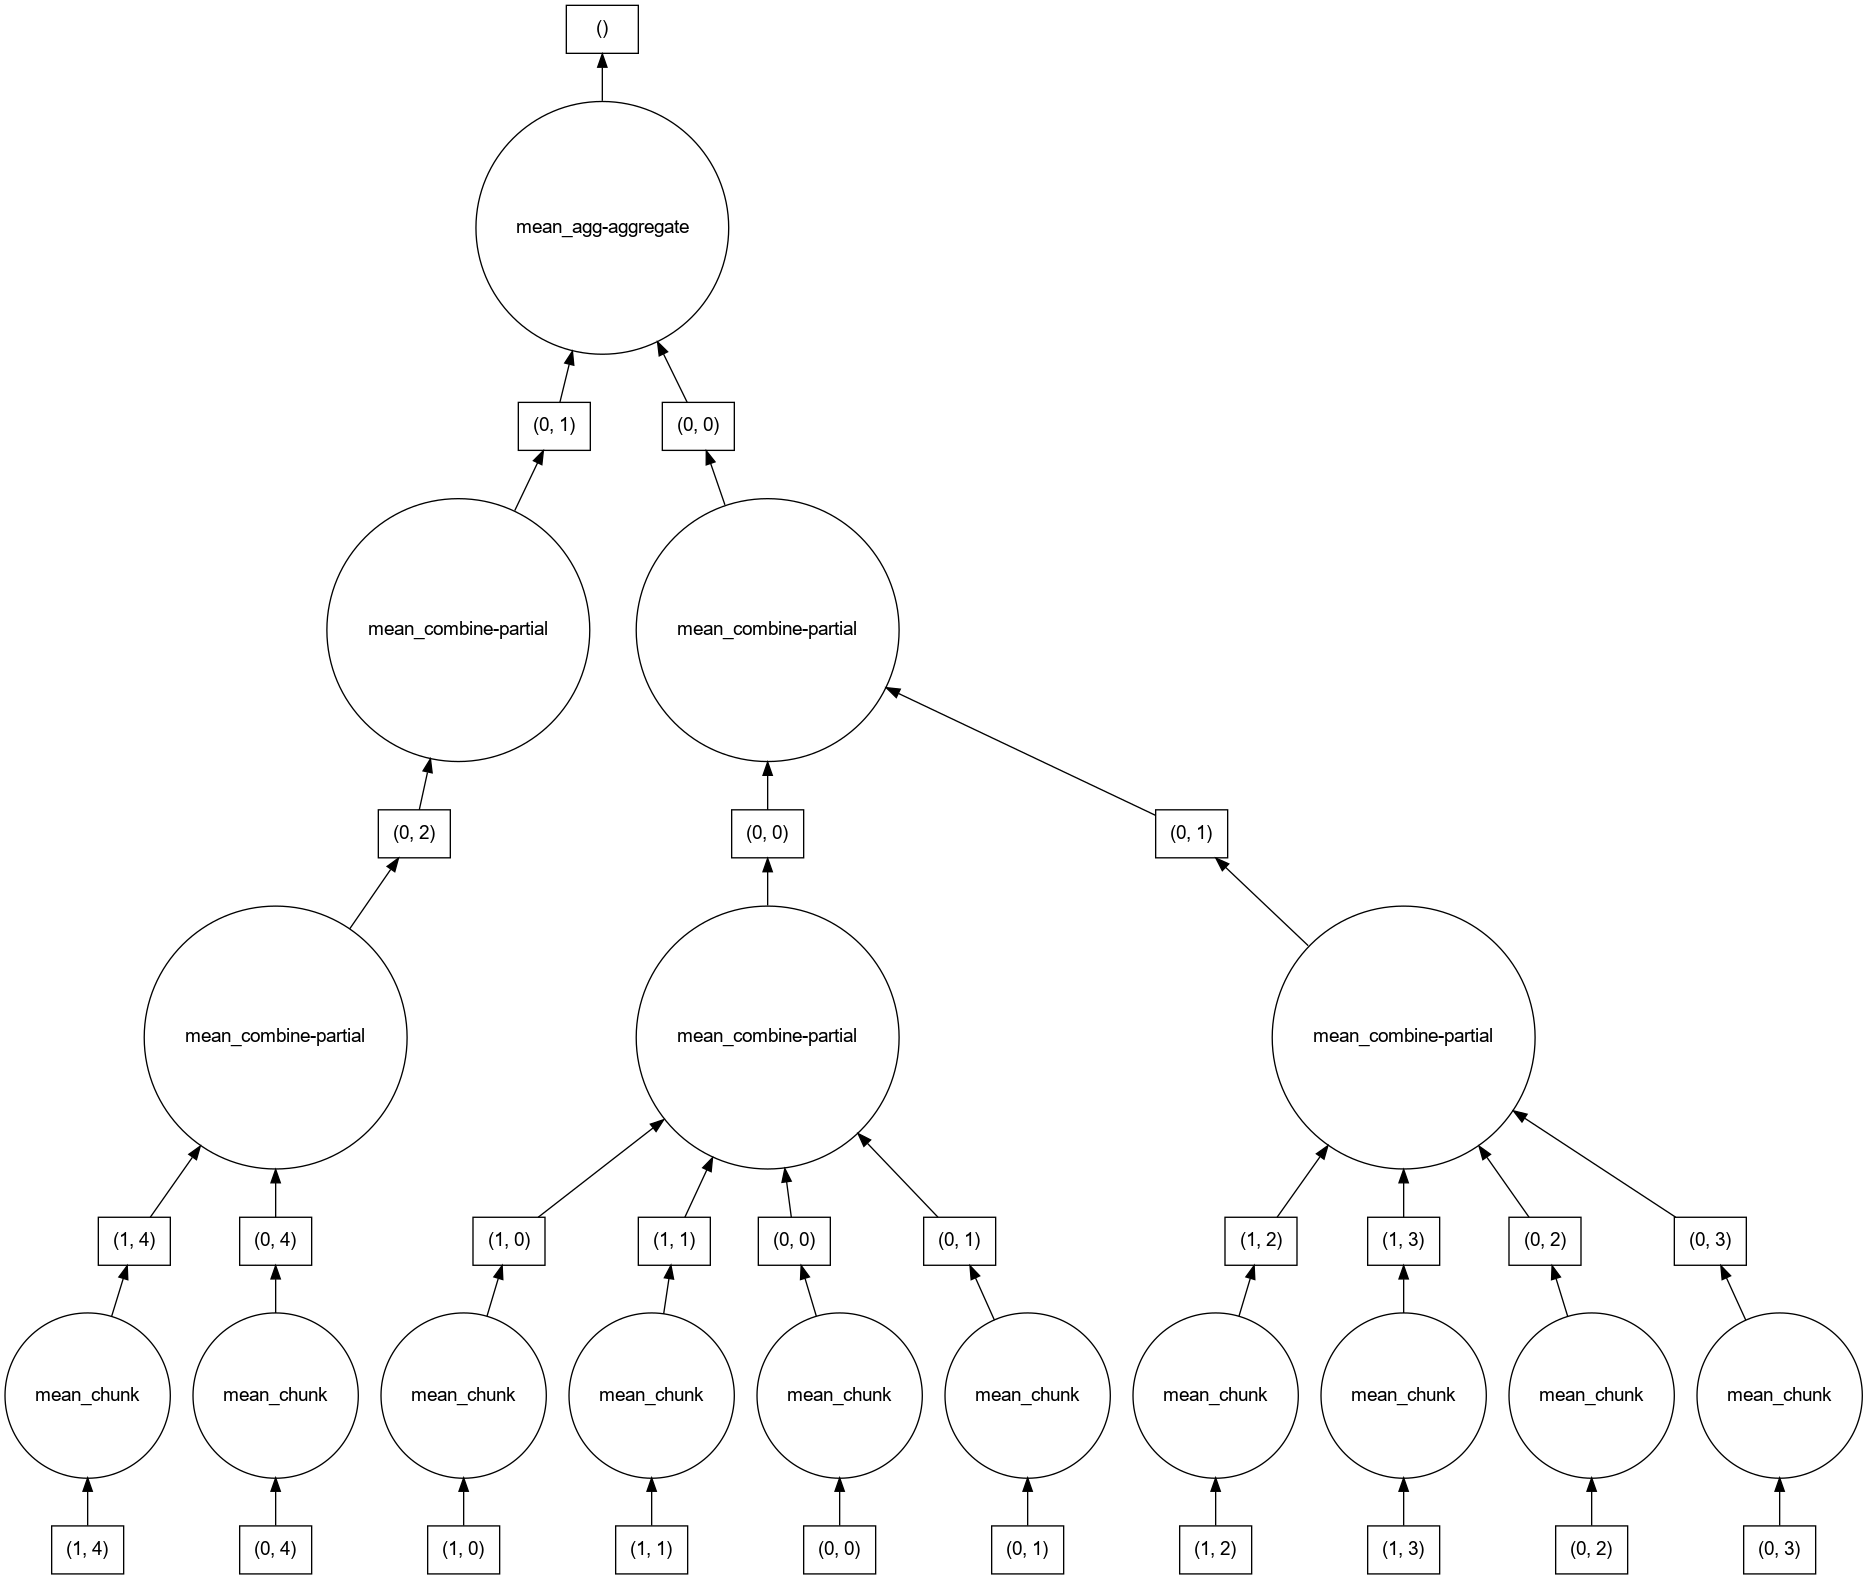

In [22]:
# visualize the task graph necessary to perform the computation
a_mean.visualize()

In [23]:
# perform the computation on the Dask array
a_mean.compute()

49999.5

In [24]:
# perform the computation on the original NumPy array
data.mean()

49999.5

#### Dask array and HDF5

* Dask arrays can be created from HDF5 files via h5py
* using chunking, extremely large data can be processed

```python
import h5py
import dask.array as da

with h5py.File('myfile.hdf5') as f:
    d = f['data']
    # d.shape # d can be very large, e.g. (1000000, 1000000)
    x = da.from_array(d, chunks=(1000, 1000))
```

### Dask `futures`

* eager evaluation of custom functions via the Dask workers
* Dask futures implements most of `concurrent.futures` for distributed processing
    * `Client.map()` $\to$ returns an iterator on the return values of the map'ped function
    * `Client.submit()` $\to$ return value must be fetched using the (blocking) `result()` call of the futures object
* futures (i.e. function and its arguments) are sent as tasks to remote workers for processing, the Dask scheduler takes care of building and updating the dependency graph

In [25]:
import time, random
from dask.distributed import Client, as_completed
# from concurrent.futures import ProcessPoolExecutor, as_completed

def g(x):
    print(f"worker g({x})")
    time.sleep(random.random())
    return x*x

print("--- map ---")
with Client() as dc:
    sq = dc.map(g, range(4))
    for n in sq:
        print(n.result())  # had to add '.result()' to concurrent.futures code

print("--- futures ---")
with Client() as dc:
    sq = {dc.submit(g, n): n for n in range(4)}
    for n in as_completed(sq):
        print(f"{n.result()}")

--- map ---
0
1
4
9
worker g(3)
worker g(1)
worker g(2)
worker g(0)
--- futures ---
0
9
4
1
worker g(2)
worker g(0)
worker g(3)
worker g(1)


### Dask `delayed`

* lazy evaluation of custom functions via the Dask workers
* Usage: `dask.delayed(function_name)(function_parameters)` to submit tasks,  
  Dask tracks the dependencies and builds up a task graph
* `compute()` method of the delayed object triggers launch of the associated task and its dependencies
* see the Dask-MPI example below for an example on delayed

### Dask-MPI

* enables the launch and use of Dask clusters based on MPI
* allows to run Dask on conventional HPC systems, without the need to bother with Cloud-specific complexity
* Dask-based computation can be submitted as batch job to the HPC system (see Monte-Carlo example)

### Example: Monte-Carlo Computation on the HPC system using Dask-MPI

$\to$ see `examples/dask-mpi/monte-carlo-pi/` for details

## Dask information resources

* https://docs.dask.org/en/stable/
* https://www.youtube.com/c/Dask-dev/videos